In [1]:
import pandas as pd
import pymongo
import config
import database as db
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import requests 
import zipfile

warnings.filterwarnings('ignore')

In [6]:
def get_market_year_ble(row):
    year = row['Year']
    week = row['Week']
    if week >= 36:
        market_year = f"{year}/{year + 1}"
    else:
        market_year = f"{year - 1}/{year}"
    return market_year

In [2]:
def get_yields():
    url = 'https://visionet.franceagrimer.fr/Pages/OpenDocument.aspx?fileurl=SeriesChronologiques%2fproductions%20vegetales%2fgrandes%20cultures%2fsurfaces%2cproductions%2crendements%2fSCR-GRC-hist_dep_surface_prod_cult_cer-A24.zip&telechargersanscomptage=oui'
    try:
        r = requests.get(url)
        r.raise_for_status()
        with open("yields/yields_report.zip", "wb") as f:
            f.write(r.content)
        print("File downloaded successfully!")

        with zipfile.ZipFile('yields/yields_report.zip', 'r') as zip_ref:
            zip_ref.extractall('yields')
        print(f"Files extracted")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    df = pd.read_csv('yields/SCR-GRC-hist_dep_surface_prod_cult_cer-A24.csv', encoding='ISO-8859-1', sep=';')
    return df

In [3]:
df = get_yields()
df['DEP'] = df['DEP'].str.replace(' ', '')
df['CULT_SURF'] = df['CULT_SURF'].str.replace(',','.').astype(float)
df['CULT_REND'] = df['CULT_REND'].str.replace(',','.').astype(float)
df['CULT_PROD'] = df['CULT_PROD'].str.replace(',','.').astype(float)
dfYieldsNA = df[df['DEP'].isin(['16','17','19','23','24','33','40','47','64','79','86','87'])]
dfYieldsNA

File downloaded successfully!
Files extracted


,ESPECES,DEP,DEPARTEMENT,REGION,ANNEE,CULT_SURF,CULT_REND,CULT_PROD
1275,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2000,460.0,45.00,2070.0
1276,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2001,500.0,40.00,2000.0
1277,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2002,1145.0,50.59,5792.5
1278,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2003,972.0,43.76,4253.0
1279,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2004,1250.0,50.00,6250.0
...,...,...,...,...,...,...,...,...
79170,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2020,399.0,80.00,3192.0
79171,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2021,399.0,85.00,3391.5
79172,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2022,399.0,90.00,3591.0
79173,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2023,399.0,105.00,4189.5


In [69]:
dfMeteo = pd.read_csv('C:/Users/alexl/Dropbox/Alex/aleexv6Corporation/Trading/Meteo/nouvelle_aquitaine_total.csv', parse_dates=['DATE'])

In [70]:
dfMeteo['TX'] = dfMeteo['TX'].replace(',', '.', regex=True).astype(float)
dfMeteo['TN'] = dfMeteo['TN'].replace(',', '.', regex=True).astype(float)
dfMeteo['TM'] = dfMeteo['TM'].replace(',', '.', regex=True).astype(float)
dfMeteo['RR'] = dfMeteo['RR'].replace(',', '.', regex=True).astype(float)
dfMeteo['DG'] = dfMeteo['DG'].replace(',', '.', regex=True).astype(float)
dfMeteo['Year'] = dfMeteo['DATE'].dt.year
dfMeteo['Week'] = dfMeteo['DATE'].dt.isocalendar().week
dfMeteo['MarketYear'] = dfMeteo.apply(get_market_year_ble, axis=1)
dfMeteo = dfMeteo[['POSTE', 'DEPARTEMENT', 'DATE', 'Week', 'Year', 'MarketYear', 'TX', 'TN', 'TM', 'RR', 'DG']]
dfMeteo

,POSTE,DEPARTEMENT,DATE,Week,Year,MarketYear,TX,TN,TM,RR,DG
0,16028001,16,2000-01-01,52,2000,2000/2001,NaN,NaN,NaN,0.3,NaN
1,33540001,33,2000-01-01,52,2000,2000/2001,12.9,8.5,8.8,0.0,NaN
2,33550001,33,2000-01-01,52,2000,2000/2001,12.0,8.8,NaN,2.0,NaN
3,64010002,64,2000-01-01,52,2000,2000/2001,11.0,7.6,8.0,2.0,0.0
4,64024001,64,2000-01-01,52,2000,2000/2001,10.3,8.4,9.1,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1769982,86289001,86,2023-12-31,52,2023,2023/2024,11.6,8.0,8.8,6.2,0.0
1769983,19164001,19,2023-12-31,52,2023,2023/2024,5.0,2.0,3.8,9.8,0.0
1769984,64010002,64,2023-12-31,52,2023,2023/2024,13.1,6.3,10.9,3.6,0.0
1769985,64233001,64,2023-12-31,52,2023,2023/2024,10.5,7.1,8.7,3.4,0.0


In [72]:
dfMeteoMeanPluieYear = dfMeteo.groupby('MarketYear').sum().iloc[:-1]
dfMeteoMeanPluieYear['Year Recolte'] = dfMeteoMeanPluieYear.index.str.split('/').str[1].astype(int)

In [87]:
dfMeteoYear = dfMeteo.groupby('MarketYear').agg({
    'TX': 'mean',
    'TN': 'mean',
    'TM': 'mean',
    'RR': 'sum',
    'DG': 'sum'
}).iloc[:-1]
dfMeteoYear['Year Recolte'] = dfMeteoYear.index.str.split('/').str[1].astype(int)

In [73]:
def filter_weeks(group):
    return group[((group['Week'] >= 36) | (group['Week'] <= 5)) & (group['Week'] < 37)]
dfMeteoMeanSemis = dfMeteo.groupby('MarketYear').apply(filter_weeks).reset_index(drop=True)
dfMeteoMeanPluieSemis = dfMeteoMeanSemis.groupby('MarketYear').sum().iloc[:-1]
dfMeteoMeanPluieSemis['Year Recolte'] = dfMeteoMeanPluieSemis.index.str.split('/').str[1].astype(int)

In [78]:
def filter_weeks(group):
    return group[((group['Week'] >= 8) | (group['Week'] <= 20))]
dfMeteoMeanMontaison = dfMeteo.groupby('MarketYear').apply(filter_weeks).reset_index(drop=True)
dfMeteoMeanMontaison = dfMeteoMeanMontaison.groupby('MarketYear').agg({
    'TX': 'mean',
    'TN': 'mean',
    'TM': 'mean',
    'RR': 'sum',
    'DG': 'sum'
}).iloc[:-1]
dfMeteoMeanMontaison['Year Recolte'] = dfMeteoMeanMontaison.index.str.split('/').str[1].astype(int)
dfMeteoMeanMontaison

,TX,TN,TM,RR,DG,Year Recolte
MarketYear,,,,,,
1999/2000,18.137243,8.061895,12.597157,110473.0,737551.0,2000
2000/2001,17.457181,8.410615,12.360052,229923.8,923614.0,2001
2001/2002,16.992390,7.269657,11.605227,147090.1,2711866.0,2002
2002/2003,18.602993,8.268459,12.907267,167956.1,2522014.0,2003
2003/2004,17.360326,7.334792,11.806323,188574.7,2212890.0,2004
2004/2005,17.704357,7.479402,12.047878,132238.3,3529888.0,2005
2005/2006,17.347567,7.510902,11.897917,175069.3,4293549.0,2006
2006/2007,17.945607,8.631838,12.755099,225916.6,2426745.0,2007
2007/2008,17.036764,7.089295,11.521315,188380.0,2672261.0,2008


In [62]:
dfYieldsNABleTendre = dfYieldsNA[dfYieldsNA['ESPECES'] == "Blé tendre d'hiver       "]
dfYieldsNABleTendreSum = dfYieldsNABleTendre.groupby('ANNEE').sum().iloc[:-1]
dfYieldsNABleTendreSum['Year Recolte'] = dfYieldsNABleTendreSum.index.astype(int)

In [88]:
dfFinalPluieYear = pd.merge(dfYieldsNABleTendreSum, dfMeteoMeanPluieYear, on='Year Recolte', how='inner')
dfFinalPluieSemis = pd.merge(dfYieldsNABleTendreSum, dfMeteoMeanPluieSemis, on='Year Recolte', how='inner')
dfFinalMontaison = pd.merge(dfYieldsNABleTendreSum, dfMeteoMeanMontaison, on='Year Recolte', how='inner')
dfFinalYear = pd.merge(dfYieldsNABleTendreSum, dfMeteoYear, on='Year Recolte', how='inner')

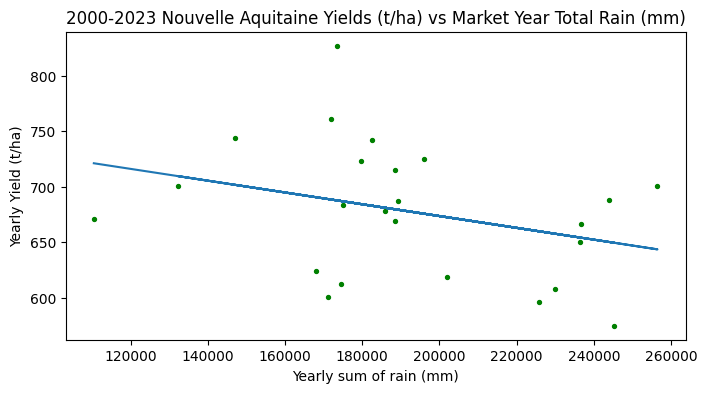

R Value : -0.32332439623344417


In [50]:
x = dfFinalPluieYear['RR']
y = dfFinalPluieYear['CULT_REND']
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 

# Calculate y values for the regression line using list comprehension
y_pred = [slope * xi + intercept for xi in x]
# Create scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='green', s=8)
plt.title('2000-2023 Nouvelle Aquitaine Yields (t/ha) vs Market Year Total Rain (mm)')
plt.xlabel('Yearly sum of rain (mm)')
plt.ylabel('Yearly Yield (t/ha)')

# Add regression line to the plot
plt.plot(x, y_pred)
plt.show()
print(f'R Value : {r_value}')

In [ ]:
dfFinalYear = dfFinalYear.set_index('Year Recolte')
dfFinalYear = dfFinalYear.drop(['CULT_SURF', 'CULT_PROD'], axis=1)

In [94]:
correlation_matrix = dfFinalYear.corr()
correlation_matrix

,CULT_REND,TX,TN,TM,RR,DG
CULT_REND,1.000000,-0.086503,-0.330374,-0.204554,-0.323324,0.154306
TX,-0.086503,1.000000,0.784796,0.956391,-0.070082,-0.090253
TN,-0.330374,0.784796,1.000000,0.923159,0.356068,-0.365581
TM,-0.204554,0.956391,0.923159,1.000000,0.155191,-0.210054
RR,-0.323324,-0.070082,0.356068,0.155191,1.000000,-0.200991
DG,0.154306,-0.090253,-0.365581,-0.210054,-0.200991,1.000000
